In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [4]:
lsbg_cat = Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')
lsbg_cat.sort('viz-id')

### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

In [5]:
meas_cat_all = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_1k.fits')
meas_cat_all[1000:2000] = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_2k.fits')[1000:2000]
meas_cat_all[2000:3000] = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_3k.fits')[2000:3000]
meas_cat_all[3000:4000] = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_4k.fits')[3000:4000]
meas_cat_all[4000:] = Table.read('./Catalog/NSA/z002_004/_lsbg_measure_vanilla_5k.fits')[4000:]

In [1]:
len(meas_cat_all[(~np.isnan(meas_cat_all['ID']))])

NameError: name 'meas_cat_all' is not defined

In [14]:
meas_cat_all.write('./Catalog/NSA/z002_004/lsbg_measure_vanilla_all.fits', overwrite=True)

### Analysis

In [6]:
import kuaizi
from kuaizi.display import plot_measurement
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)

In [7]:
meas_cat = Table.read('./Catalog/NSA/z002_004/lsbg_measure_vanilla_all.fits')

In [8]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [9]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

# of Candy: 1276
# of Gal: 2404
# of Junk: 1896


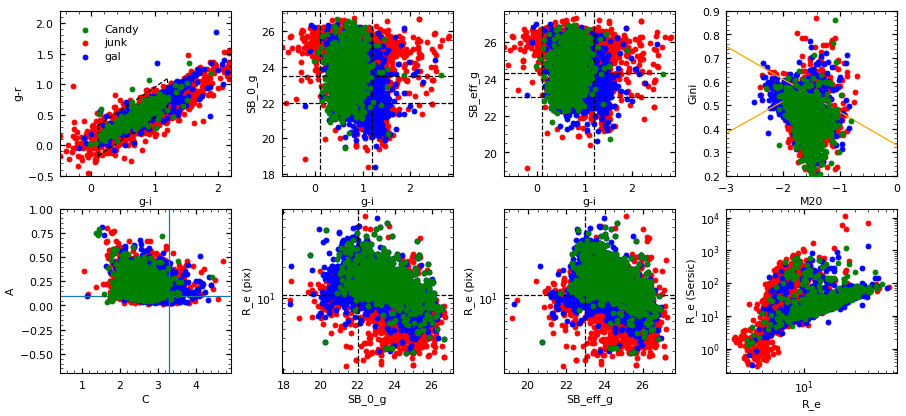

In [10]:
plot_measurement(lsbg_cat, meas_cat)

In [11]:
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['rhalf_circularized'] > 1.6 / 0.168) & (meas_cat['rhalf_circularized'] < 12 / 0.168)# & (meas_cat['r20'] > 1 / 0.168)
#mask &= (meas_cat['rhalf_ellip'] > 1.8 / 0.168) & (meas_cat['rhalf_ellip'] < 12 / 0.168)

mask &= (meas_cat['SB_0'][:, 0] > 22.0)

#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.8) # Cuts based on JL votes
#mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.) # Cuts based on JG votes
mask &= (meas_cat['SB_eff_avg'][:, 0] > 23.0) # Cuts based on JG votes

mask &= (meas_cat['ell_sym'] < 0.65)

mask &= (meas_cat['M20'] < -1.1)
mask &= (meas_cat['Gini'] < 0.7)
mask &= ~((meas_cat['M20'] < -1.6) & (
    meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))

mask &= (meas_cat['C'] < 3.5)
#mask &= (meas_cat['A_outer'] <= 0.13)


print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 954
Gal: 1026
Junk: 99


# of Candy: 954
# of Gal: 1026
# of Junk: 99


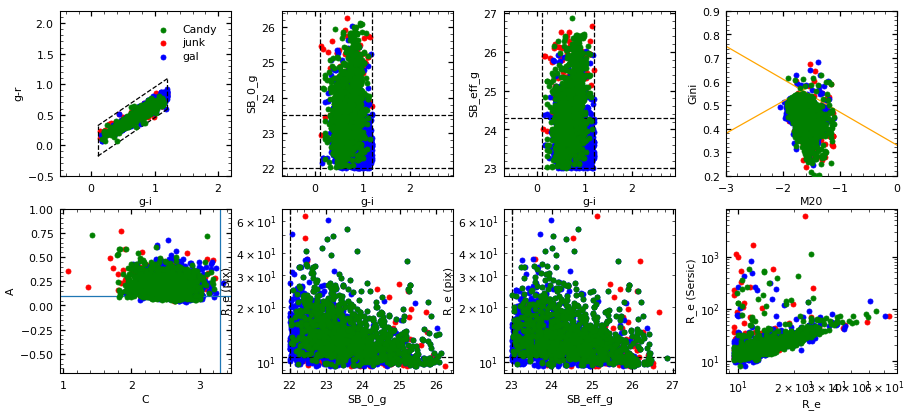

In [12]:
plot_measurement(lsbg_cat[mask], meas_cat[mask])

### Save catalog

In [90]:
# lsbg_cat['host_RA'] = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004.fits')[100:]['host_RA']
# lsbg_cat['host_DEC'] = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004.fits')[100:]['host_DEC']

In [18]:
from astropy.table import hstack
hstack([lsbg_cat[mask], meas_cat[mask]]
      ).write('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004_after_cuts_JG.fits', overwrite=True)

In [13]:
cuts_cat = Table.read('./Catalog/NSA/z002_004/lsbg_NSA_MW_z002_004_after_cuts_JG.fits')

In [14]:
len(cuts_cat)

2079

In [15]:
from astropy.coordinates import SkyCoord

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

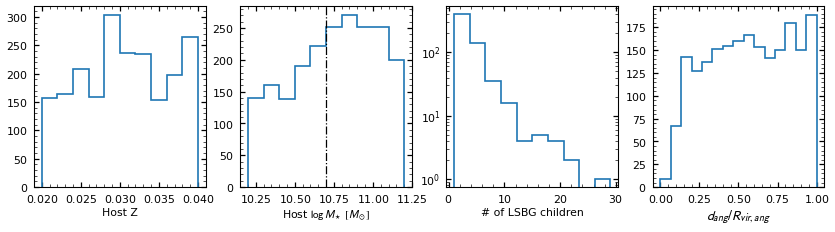

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2);
plt.xlabel('Host Z')

plt.sca(axes[1])
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2);
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(cuts_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')
host_coord = SkyCoord(cuts_cat['host_RA'], cuts_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / cuts_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=15, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

In [17]:
ang_diam_dist = cuts_cat['host_ang_diam_dist'] # not consider peculiar motion

rhalf_phys = cuts_cat['rhalf_circularized'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_circularized_phys'] = rhalf_phys

rhalf_phys = cuts_cat['rhalf_ellip'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
cuts_cat['rhalf_ellip_phys'] = rhalf_phys

In [18]:
cuts_cat['abs_mag'] = cuts_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri
BV = 0.62 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) + 0.15
V = cuts_cat['mag'][:, 0] - 0.52 * (cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
log_ML_V = 1.493 * BV - 0.681
M = (4.83 - V_abs) / (2.5) + log_ML_V
cuts_cat['log_m_star'] = M
cuts_cat['V_abs'] = V_abs

In [19]:
### UDGs
flag = (cuts_cat['rhalf_circularized_phys'] > 1.3) & (cuts_cat['SB_0'][:, 0] >= 24.5)# & (cuts_cat['sersic_ell'] < 0.7)
print('# of UDGs:', np.sum(flag))

# of UDGs: 105


In [20]:
udg_cat = cuts_cat[flag]

In [21]:
udg_cat['viz-id'].data

array([  931,  1760,  2071,  4032,  4188,  4221,  4363,  5051,  6675,
       11959, 12500, 12814, 13292, 14037, 14970, 15381, 15401, 17439,
       17947, 18077, 19656, 19965, 21244, 21384, 21531, 22086, 23739,
       24267, 25205, 27799, 28347, 29725, 30027, 30675, 32512, 33007,
       33394, 34727, 35129, 38086, 38470, 39390, 40671, 40955, 41290,
       41501, 44405, 44841, 44926, 45970, 46914, 47949, 48838, 49557,
       51149, 51341, 51815, 52367, 52915, 54980, 57828, 58901, 59939,
       60199, 60461, 60721, 62121, 62214, 62470, 63264, 63430, 64077,
       64379, 64482, 64638, 65334, 66772, 69656, 70143, 72306, 74461,
       74926, 75879, 76145, 78228, 79056, 79133, 79706, 80065, 81294,
       81343, 81848, 82230, 82983, 83554, 84101, 84314, 85545, 85715,
       86966, 88425, 88587, 89144, 89269, 90593])

In [22]:
udg_cat.write('./Catalog/NSA/z002_004/UDG_NSA_MW_z002_004_JG.fits', overwrite=True)

In [23]:
### Then I vote

In [24]:
### Non-UDG index from visual inspection
ids = np.array([1760, 12500, 17439, 28347, 
                30027, 30675, 39390, 41501, 49557, 
                63848, 64077, 64379, 66143, 
                78228, 81848, 86966, ])

In [96]:
len(ids) / len(udg_cat)

0.1523809523809524

In [25]:
udg_cat = udg_cat[~np.in1d(udg_cat['viz-id'].data, ids)]

In [77]:
len(udg_cat)

91

In [36]:
len(np.unique(lsbg_cat['host_name']))

754

In [105]:
len(np.unique(cuts_cat['host_name'])), len(cuts_cat)

(608, 2079)

In [112]:
inds = np.random.choice(np.arange(len(cuts_cat)), int(len(cuts_cat) * 0.85), replace=False)

In [113]:
len(np.unique(cuts_cat[inds]['host_name'])), len(cuts_cat[inds])

(570, 1767)

In [38]:
len(np.unique(udg_cat['host_name']))

75

In [114]:
570 / 6

95.0

In [115]:
91 * 0.95

86.45

In [116]:
570 / 86

6.627906976744186

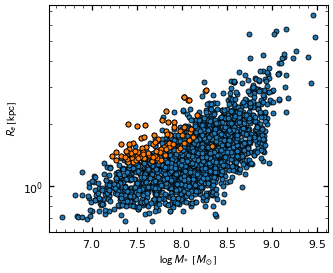

In [43]:
plt.scatter(cuts_cat['log_m_star'], cuts_cat['rhalf_circularized_phys'])
plt.scatter(udg_cat['log_m_star'], udg_cat['rhalf_circularized_phys'])

plt.xlabel(r'$\log\, M_*\ [M_\odot]$')
plt.ylabel(r'$R_e\ [\rm kpc]$')

plt.yscale('log')

In [27]:
red = ((udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]) > 0.8)

(24.0, 28.0)

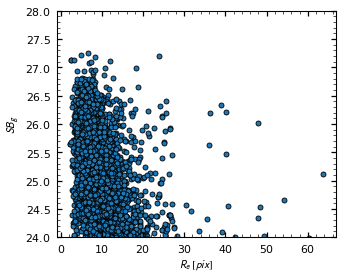

In [34]:
plt.scatter(meas_cat['rhalf_circularized'], meas_cat['SB_eff_avg'][:, 0])
#plt.scatter(cuts_cat['log_m_star'][flag], cuts_cat['rhalf_ellip_phys'][flag])


plt.xlabel(r'$R_e\ [pix]$')
plt.ylabel(r'$SB_g$')
plt.ylim(24, 28)

Text(0, 0.5, '$SB_g$')

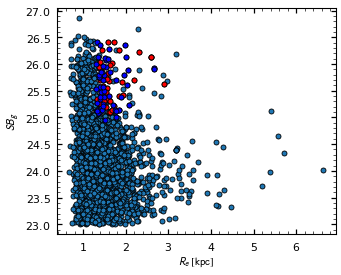

In [29]:
plt.scatter(cuts_cat['rhalf_circularized_phys'], cuts_cat['SB_eff_avg'][:, 0])
plt.scatter(udg_cat['rhalf_circularized_phys'][red], udg_cat['SB_eff_avg'][:, 0][red], c='red')
plt.scatter(udg_cat['rhalf_circularized_phys'][~red], udg_cat['SB_eff_avg'][:, 0][~red], c='b')
#plt.scatter(cuts_cat['log_m_star'][flag], cuts_cat['rhalf_ellip_phys'][flag])


plt.xlabel(r'$R_e\ [\rm kpc]$')
plt.ylabel(r'$SB_g$')

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

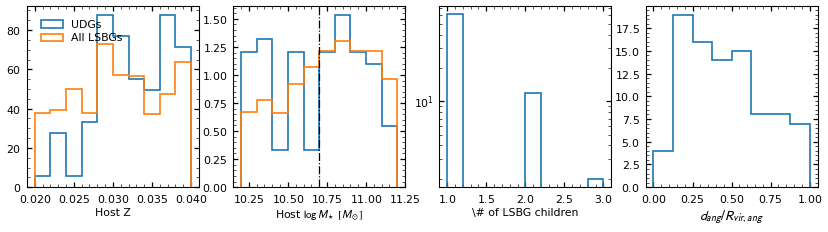

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(udg_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel('Host Z')
plt.legend(loc='upper left')

plt.sca(axes[1])
plt.hist(udg_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='UDGs');
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2, density=True, label='All LSBGs');
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(udg_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('\# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=8, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

In [127]:
12 ** 2

144

In [136]:
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/decals-image-list-tool/udg_z002_004.txt', 
    format='ascii')

### UDG plots

In [98]:
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

In [99]:
kz.set_matplotlib(dpi=100, fontsize=15)

In [100]:
gi_color = udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]

(-12.0, -16.0)

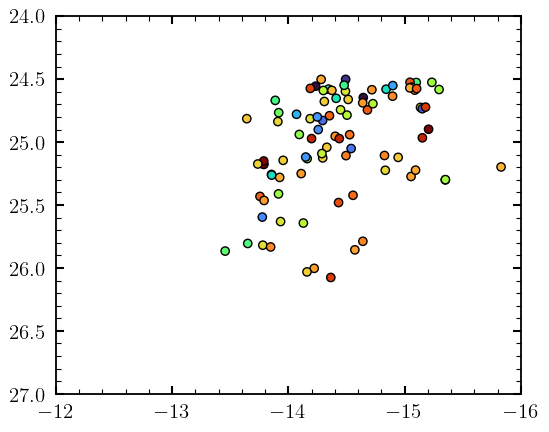

In [103]:
sct = plt.scatter(udg_cat['V_abs'], 
                  udg_cat['SB_0'][:, 0], 
            c=gi_color,
            label='UDGs')

plt.ylim(27, 24)
plt.xlim(-12, -16)

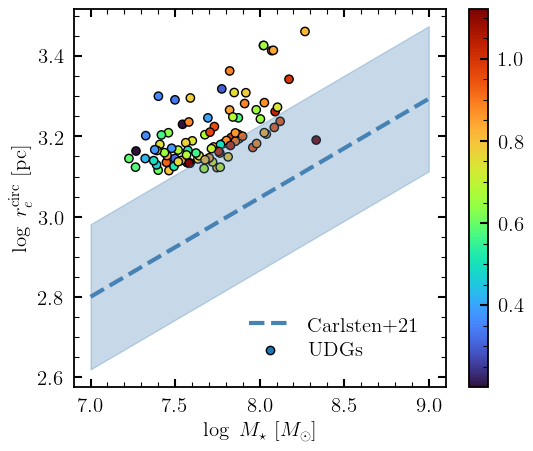

In [49]:
sct = plt.scatter(udg_cat['log_m_star'], 
            np.log10(udg_cat['rhalf_circularized_phys']) + 3, 
            c=gi_color,
            label='UDGs')

plt.colorbar()

x = np.linspace(7, 9)
plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
                 mass_size_carlsten(x) + 0.181, 
                 color='steelblue', alpha=0.3)
plt.plot(x, mass_size_carlsten(x), ls='--', 
         color='steelblue', lw=3, label='Carlsten+21')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(loc='lower right')

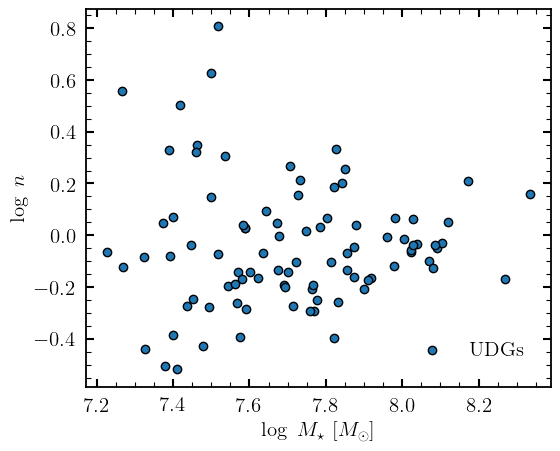

In [50]:
sct = plt.scatter(udg_cat['log_m_star'], 
            np.log10(udg_cat['sersic_n']), 
            label='UDGs')

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ n$')
plt.legend(loc='lower right')

In [51]:
from scipy.stats import binned_statistic

In [52]:
quench_frac, bin_edges, _ = binned_statistic(udg_cat['log_m_star'], (gi_color > 0.8), 
                                             statistic='mean', range=(7, 9), bins=8)
num, bin_edges, _ = binned_statistic(udg_cat['log_m_star'], (gi_color > 0.8), 
                                             statistic='count', range=(7, 9), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

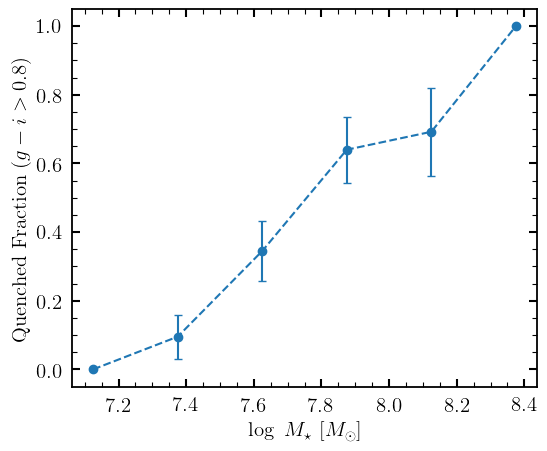

In [53]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [119]:
quench_frac, bin_edges, _ = binned_statistic(udg_cat['host_stellar_mass'], (gi_color > 0.8), 
                                             statistic='mean', range=(10.2, 11.2), bins=8)
num, bin_edges, _ = binned_statistic(udg_cat['host_stellar_mass'], (gi_color > 0.8), 
                                             statistic='count', range=(10.2, 11.2), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

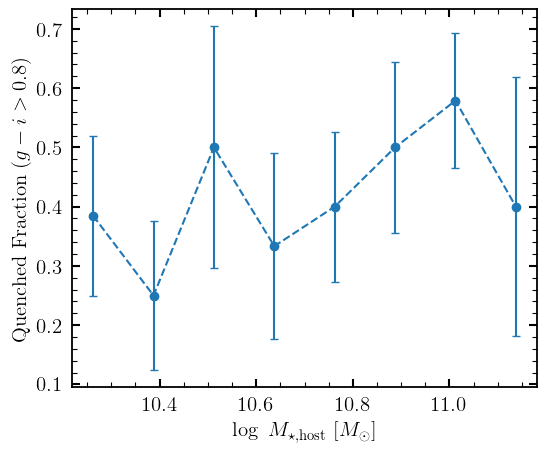

In [120]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_{\star, \rm host}\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [123]:
quench_frac, bin_edges, _ = binned_statistic(udg_cat['host_halo_mass'], (gi_color > 0.8), 
                                             statistic='mean', range=(11.7, 13.5), bins=8)
num, bin_edges, _ = binned_statistic(udg_cat['host_halo_mass'], (gi_color > 0.8), 
                                             statistic='count', range=(11.7, 13.5), bins=8)

Text(0, 0.5, 'Quenched Fraction ($g - i > 0.8$)')

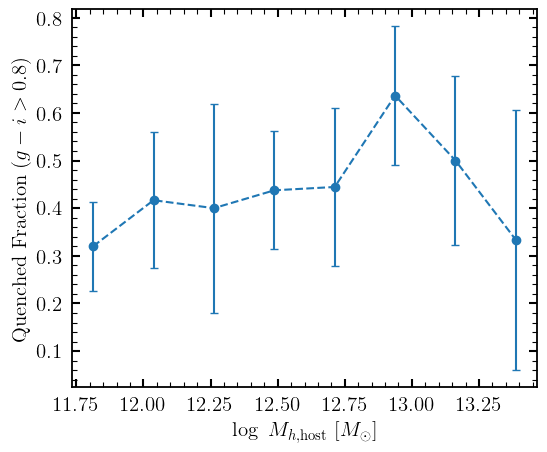

In [124]:
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, 
             quench_frac, yerr=np.sqrt(quench_frac * (1 - quench_frac) / num), fmt='o--')
plt.xlabel(r'$\log\ M_{h, \rm host}\ [M_\odot]$')
plt.ylabel(r'Quenched Fraction ($g - i > 0.8$)')

In [266]:
yagi_cat = Table.read('./Catalog/Yagi+16.fits')

In [221]:
flag = (yagi_cat['Re1'].data.data > 1.5)# & (yagi_cat['SuBr0'].data.data > 24.5)
yagi_cat = yagi_cat[flag]

In [222]:
yagi_cat['log_m_star'] = (4.83 - yagi_cat['Rmag1'] + 35.05) / (2.5)

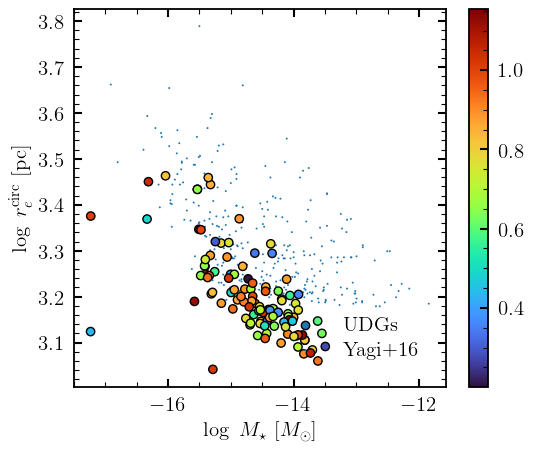

In [223]:
sct = plt.scatter(udg_cat['abs_mag'][:, 1], 
            np.log10(udg_cat['rhalf_circ_phys']) + 3, 
            c=gi_color,
            label='UDGs')
plt.colorbar()

#x = np.linspace(7, 9)
# plt.fill_between(x, mass_size_carlsten(x) - 0.181, 
#                  mass_size_carlsten(x) + 0.181, 
#                  color='steelblue', alpha=0.3)
# plt.plot(x, mass_size_carlsten(x), ls='--', 
#          color='steelblue', lw=3, label='Carlsten+21')


plt.scatter(yagi_cat['Rmag1'] - 35.05, np.log10(yagi_cat['Re1']) + 3, 
            label='Yagi+16', edgecolor='none', s=2, zorder=0)

plt.xlabel(r'$\log\ M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_{e}^{\rm circ}\ [\rm pc]$')
plt.legend(loc='lower right')

In [226]:
yagi_cat = Table.read('./Catalog/Yagi+16.fits')

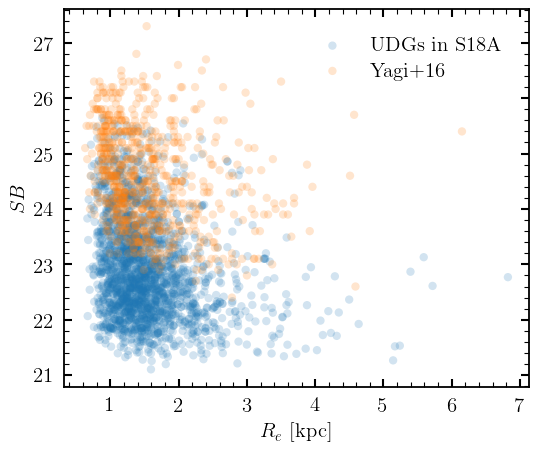

In [227]:
plt.scatter(cuts_cat['rhalf_circ_phys'], cuts_cat['SB_0'][:, 1], label='UDGs in S18A', alpha=0.2, edgecolor='none')
plt.scatter(yagi_cat['Re1'], yagi_cat['SuBr0'], label='Yagi+16', alpha=0.2, edgecolor='none')
#plt.scatter(cuts_cat['log_m_star'][flag], cuts_cat['rhalf_ellip_phys'][flag])


plt.xlabel(r'$R_e\ [\rm kpc]$')
plt.ylabel(r'$SB$')
plt.legend()